<a href="https://colab.research.google.com/github/AnIsAsPe/LogisticRegression_SpamOpinion/blob/master/Notebooks/Clasificador_rese%C3%B1as_Regresi%C3%B3n_log%C3%ADstica_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Bibliotecas

In [4]:
!pip install contractions

In [7]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer  ## SnowballStemmer (para español)
import contractions

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hectorip/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hectorip/nltk_data...


True

# Funciones

In [8]:
def elimina_stopwords(texto):
  '''La función usa expresiones regulares (re) para quitar todas las palabras
  que sean una palabra vacia:'''
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto)
  return nuevo_texto

# https://www.regular-expressions.info/index.html
# https://www.tutorialspoint.com/Why-do-we-use-re-compile-method-in-Python-regular-expression

In [9]:
elimina_stopwords("I love how you cook".lower())

'love cook'

In [10]:
def elimina_puntuacion_y_numeros(texto):
  nuevo_texto = re.sub('[^a-z]+', ' ', texto)
  return nuevo_texto


In [11]:
elimina_puntuacion_y_numeros("Is he 8 years old?".lower())

'is he years old '

In [12]:
"Is he 8 years old?".split()

['Is', 'he', '8', 'years', 'old?']

In [13]:
def lematizar(texto):
  lemma = WordNetLemmatizer()
  texto = texto.split()
  texto2 = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  nuevo_texto = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  return nuevo_texto

In [14]:
lematizar("ran run running")

'run run run'

In [15]:
def stemmer(texto):
  st = PorterStemmer()
  texto = texto.split()
  nuevo_texto = ' '.join([st.stem(i) for i in texto])

  ## Para ESPAÑOL
  # st = SnowballStemmer("spanish")
  # texto = texto.split()
  # nuevo_texto = ' '.join([st.stem(i) for i in texto])

  return nuevo_texto

In [16]:
stemmer("ran run running")

'ran run run'

In [17]:
def preprocesar(texto):
  texto = contractions.fix(texto)
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion_y_numeros(texto)
  texto = stemmer(texto)
  return(texto)


In [18]:
def evaluación(modelo, conjunto):
    mensaje_error = 'conjunto solo puede ser "entrenamieonto" o "prueba"'
    assert conjunto in ['entrenamiento', 'prueba'], mensaje_error


    if conjunto == 'entrenamiento':
      X = X_train
      y = y_train
    else:
      X = X_test
      y = y_test


    y_pred = modelo.predict(X)
    precision = accuracy_score(y, y_pred)*100

    # creamos un diccionario con las etiquetas
    data = {'y_Real':  y,
            'y_Prediccion': y_pred
            }
    # lo convertimos en un DataFrame de pandas
    df = pd.DataFrame(data, columns=['y_Real','y_Prediccion'])

    # hacemos una tabla crusada para obtener la matriz de confusión
    confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'],
                                   rownames=['Real'], colnames=['Predicción'])

    # realizamos un mapa de calor
    titulo = 'Datos:{}, precisión = {:4.2f}'.format(conjunto, precision)
    sns.heatmap(confusion_matrix, annot=True, fmt='g').set(title = titulo)
    plt.show()


In [19]:
def grafica_roc(clf, y_test):
    '''Grafica la curva ROC para el conjunto de prueba'''
    y_test_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve( y_test, y_test_score)
    roc_auc = auc(fpr, tpr)  #Area bajo la curva (AUC, por sus siglas en inglés)
    plt.figure()
    plt.plot(fpr, tpr, label="Curva ROC (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate ")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

# Lectura de datos y breve exploración

In [20]:
datos = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/LogisticRegression_SpamOpinion/master/Datos/deceptive-opinion.csv',
                     usecols=['deceptive','text']
                    )
print(datos.shape)
datos.head()

(1600, 2)


,deceptive,text
0,truthful,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...
3,truthful,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...


In [21]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   text       1600 non-null   object
dtypes: object(2)
memory usage: 25.1+ KB


In [22]:
datos.deceptive.value_counts()

deceptive
truthful     800
deceptive    800
Name: count, dtype: int64

In [23]:
# datos['deceptive'] = np.where(datos['deceptive']=='deceptive', 1, 0)
# datos['deceptive'].value_counts()

In [24]:
y = datos['deceptive']

# Preprocesamiento de texto

In [25]:
datos['text']

0       We stayed for a one night getaway with family ...
1       Triple A rate with upgrade to view room was le...
2       This comes a little late as I'm finally catchi...
3       The Omni Chicago really delivers on all fronts...
4       I asked for a high floor away from the elevato...
                              ...                        
1595    Problems started when I booked the InterContin...
1596    The Amalfi Hotel has a beautiful website and i...
1597    The Intercontinental Chicago Magnificent Mile ...
1598    The Palmer House Hilton, while it looks good i...
1599    As a former Chicagoan, I'm appalled at the Ama...
Name: text, Length: 1600, dtype: object

In [26]:
datos['long_text'] = datos['text'].str.split().str.len()

In [27]:
datos

,deceptive,text,long_text
0,truthful,We stayed for a one night getaway with family ...,105
1,truthful,Triple A rate with upgrade to view room was le...,45
2,truthful,This comes a little late as I'm finally catchi...,207
3,truthful,The Omni Chicago really delivers on all fronts...,127
4,truthful,I asked for a high floor away from the elevato...,72
...,...,...,...
1595,deceptive,Problems started when I booked the InterContin...,131
1596,deceptive,The Amalfi Hotel has a beautiful website and i...,121
1597,deceptive,The Intercontinental Chicago Magnificent Mile ...,141
1598,deceptive,"The Palmer House Hilton, while it looks good i...",86


In [28]:
datos['long_text'].describe()

count    1600.000000
mean      148.775000
std        87.335984
min        25.000000
25%        88.000000
50%       128.000000
75%       182.250000
max       784.000000
Name: long_text, dtype: float64

In [29]:
datos[datos['long_text']==784]

,deceptive,text,long_text
1473,deceptive,"For a hotel rated with four diamonds by AAA, o...",784


In [31]:
indice = 1473
ejemplo = datos.loc[indice, 'text']
ejemplo

"For a hotel rated with four diamonds by AAA, one would think the Hilton Chicago would be almost like staying at a palace with royalty. The only royal thing about this hotel however is that it was a royal nightmare. I should have known from the moment I walked in with my wife that this was going to become a bigger headache than what it was worth. First off, as soon as we arrived to check in at the hotel with the clerk who couldn't be any older than nineteen or twenty, red flags started going up. The clerk was extremely rude and lazy, acting like it was a chore even getting up from texting on his cell phone. If that wasn't bad enough, the clerk pretty much ignored me while blatantly staring at my wife's breasts. She wasn't even wearing anything that could be considered skimpy as it was cold out and she was wearing a turtle neck sweater under a large fur lined coat. After diverting his atention several times we finally got our room keys. It shouldn't have been any surprise when we learne

#### Transformar contracciones

In [32]:
ejemplo = contractions.fix(ejemplo)
ejemplo

"For a hotel rated with four diamonds by AAA, one would think the Hilton Chicago would be almost like staying at a palace with royalty. The only royal thing about this hotel however is that it was a royal nightmare. I should have known from the moment I walked in with my wife that this was going to become a bigger headache than what it was worth. First off, as soon as we arrived to check in at the hotel with the clerk who could not be any older than nineteen or twenty, red flags started going up. The clerk was extremely rude and lazy, acting like it was a chore even getting up from texting on his cell phone. If that was not bad enough, the clerk pretty much ignored me while blatantly staring at my wife's breasts. She was not even wearing anything that could be considered skimpy as it was cold out and she was wearing a turtle neck sweater under a large fur lined coat. After diverting his atention several times we finally got our room keys. It should not have been any surprise when we le

#### Transformar texto a minúsculas

In [33]:
ejemplo = ejemplo.lower()
ejemplo

"for a hotel rated with four diamonds by aaa, one would think the hilton chicago would be almost like staying at a palace with royalty. the only royal thing about this hotel however is that it was a royal nightmare. i should have known from the moment i walked in with my wife that this was going to become a bigger headache than what it was worth. first off, as soon as we arrived to check in at the hotel with the clerk who could not be any older than nineteen or twenty, red flags started going up. the clerk was extremely rude and lazy, acting like it was a chore even getting up from texting on his cell phone. if that was not bad enough, the clerk pretty much ignored me while blatantly staring at my wife's breasts. she was not even wearing anything that could be considered skimpy as it was cold out and she was wearing a turtle neck sweater under a large fur lined coat. after diverting his atention several times we finally got our room keys. it should not have been any surprise when we le

#### Quitar puntuación

In [34]:
ejemplo = elimina_puntuacion_y_numeros(ejemplo)
ejemplo

'for a hotel rated with four diamonds by aaa one would think the hilton chicago would be almost like staying at a palace with royalty the only royal thing about this hotel however is that it was a royal nightmare i should have known from the moment i walked in with my wife that this was going to become a bigger headache than what it was worth first off as soon as we arrived to check in at the hotel with the clerk who could not be any older than nineteen or twenty red flags started going up the clerk was extremely rude and lazy acting like it was a chore even getting up from texting on his cell phone if that was not bad enough the clerk pretty much ignored me while blatantly staring at my wife s breasts she was not even wearing anything that could be considered skimpy as it was cold out and she was wearing a turtle neck sweater under a large fur lined coat after diverting his atention several times we finally got our room keys it should not have been any surprise when we learned that th

#### Quitar Palabras Irrelevantes ("Stopwords")

In [35]:
ejemplo = elimina_stopwords(ejemplo)
ejemplo

'hotel rated four diamonds aaa one would think hilton chicago would almost like staying palace royalty royal thing hotel however royal nightmare known moment walked wife going become bigger headache worth first soon arrived check hotel clerk could older nineteen twenty red flags started going clerk extremely rude lazy acting like chore even getting texting cell phone bad enough clerk pretty much ignored blatantly staring wife breasts even wearing anything could considered skimpy cold wearing turtle neck sweater large fur lined coat diverting atention several times finally got room keys surprise learned one help us luggage clerk said break okay annoying managed easy enough finally got third floor suite reserved month looked forward resting long trip surprise mention disgust horror already couple supposed room bed making took almost half hour couple room front desk wife get straightened apparently night clerk bother following policy taken reservation computer give friends leaving printed

## Normalización
Existen dos principales técnicas para normalizar el texto, la lematización y "radicalización" o stemming, que consiste en la  conversión de palabras en las raices

Referencia:

https://towardsdatascience.com/introduction-to-nlp-part-2-difference-between-lemmatisation-and-stemming-3789be1c55bc

In [36]:
ejemplo_lema = lematizar(ejemplo)
ejemplo_lema

'hotel rat four diamonds aaa one would think hilton chicago would almost like stay palace royalty royal thing hotel however royal nightmare know moment walk wife go become bigger headache worth first soon arrive check hotel clerk could older nineteen twenty red flag start go clerk extremely rude lazy act like chore even get texting cell phone bad enough clerk pretty much ignore blatantly star wife breast even wear anything could consider skimpy cold wear turtle neck sweater large fur line coat divert atention several time finally get room key surprise learn one help us luggage clerk say break okay annoy manage easy enough finally get third floor suite reserve month look forward rest long trip surprise mention disgust horror already couple suppose room bed make take almost half hour couple room front desk wife get straighten apparently night clerk bother follow policy take reservation computer give friends leave print card day clerk could describe chaos finally give another room next fl

In [37]:
ejemplo_stem = stemmer(ejemplo)
ejemplo_stem

'hotel rate four diamond aaa one would think hilton chicago would almost like stay palac royalti royal thing hotel howev royal nightmar known moment walk wife go becom bigger headach worth first soon arriv check hotel clerk could older nineteen twenti red flag start go clerk extrem rude lazi act like chore even get text cell phone bad enough clerk pretti much ignor blatantli stare wife breast even wear anyth could consid skimpi cold wear turtl neck sweater larg fur line coat divert atent sever time final got room key surpris learn one help us luggag clerk said break okay annoy manag easi enough final got third floor suit reserv month look forward rest long trip surpris mention disgust horror alreadi coupl suppos room bed make took almost half hour coupl room front desk wife get straighten appar night clerk bother follow polici taken reserv comput give friend leav print card day clerk could describ chao final given anoth room next floor thank got wife went use bathroom drop luggag bed h

## Todo junto

In [38]:
datos['text_pp'] = datos['text'].apply(preprocesar)
datos['long_text_pp'] = datos['text_pp'].str.split().str.len()
datos.head()

,deceptive,text,long_text,text_pp,long_text_pp
0,truthful,We stayed for a one night getaway with family ...,105,stay one night getaway famili thursday tripl a...,58
1,truthful,Triple A rate with upgrade to view room was le...,45,tripl rate upgrad view room less also includ b...,30
2,truthful,This comes a little late as I'm finally catchi...,207,come littl late final catch review past sever ...,104
3,truthful,The Omni Chicago really delivers on all fronts...,127,omni chicago realli deliv front spacious room ...,63
4,truthful,I asked for a high floor away from the elevato...,72,ask high floor away elev got room pleasantli d...,33


# Visualización de nubes de palabras

In [41]:
def nube_palabras(sec_textos):
    # Crear la cadena con la que haremos la nube de palabras
    text= " ".join(review for review in sec_textos)

    # Crear la nube de palabras
    wordcloud = WordCloud( max_font_size=50,
                          max_words=100,
                          background_color="white").generate(text)

    # Desplegar la imagen generada
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

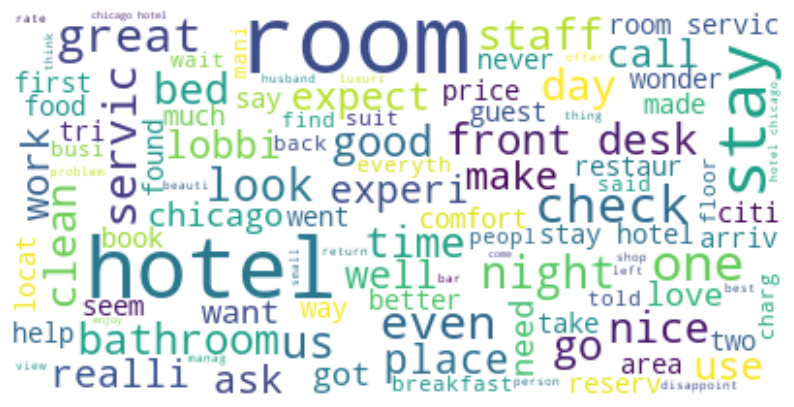

In [42]:
nube_palabras(datos['text_pp'])

In [45]:
porClase = datos.groupby('deceptive')
verdaderas = porClase.get_group('truthful').text_pp
falsas = porClase.get_group('deceptive').text_pp

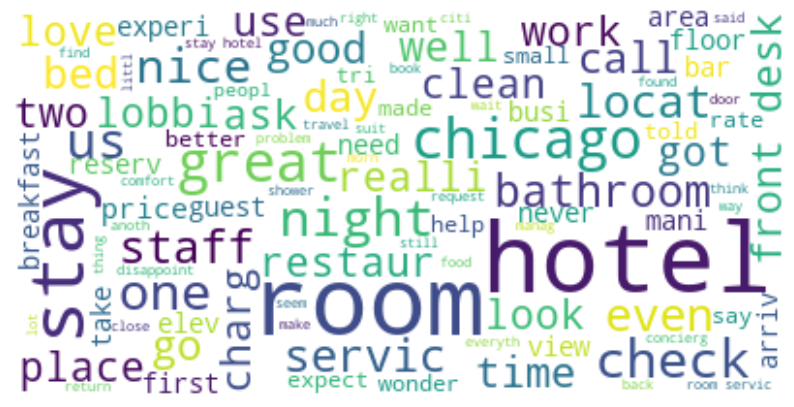

In [46]:
nube_palabras(verdaderas)

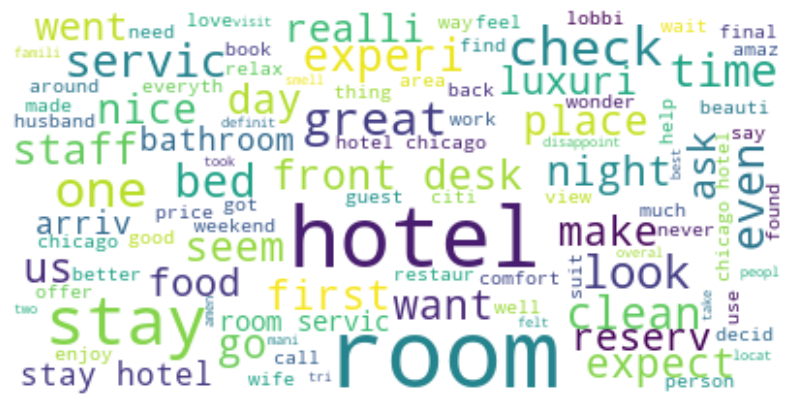

In [47]:
nube_palabras(falsas)

# Vectorización de Texto mediante BOW

In [48]:
vectorizer = TfidfVectorizer(min_df=2)
BOW = vectorizer.fit_transform(datos['text_pp'])
BOW.shape

(1600, 3597)

In [49]:
BOW

<1600x3597 sparse matrix of type '<class 'numpy.float64'>'
	with 92334 stored elements in Compressed Sparse Row format>

In [50]:
type(BOW)

scipy.sparse._csr.csr_matrix

In [52]:
palabras = vectorizer.get_feature_names_out()
X = pd.DataFrame(BOW.todense(), index=datos.index, columns=palabras)
X

,aaa,abil,abl,abrupt,absenc,absent,absolut,absurd,abund,abysm,...,york,young,younger,yr,yuck,yummi,yup,zest,zone,zoo
0,0.189205,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.08608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1596,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1598,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Regresión Logística sin penalización

In [99]:
# Dividir datos en entrenamiento y prueba
X_train, X_test , y_train, y_test = train_test_split(X, y,
                                                     test_size=0.1,
                                                     shuffle=True,
                                                     random_state=9
                                                     )

clasificador_rl = LogisticRegression(penalty= None,
                                     random_state=4,
                                     solver="newton-cg").fit(X_train, y_train)

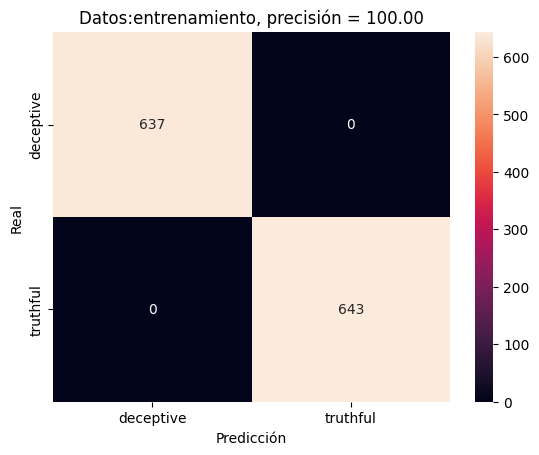

In [65]:
evaluación(clasificador_rl, 'entrenamiento')

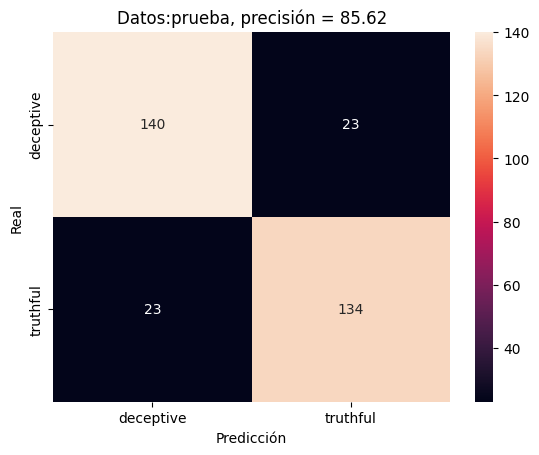

In [66]:
evaluación(clasificador_rl, 'prueba')

# Regresión Logística con penalización Ridge

## ¿De qué magnitud debe ser la fueza de la regularización (parámetro  λ)?

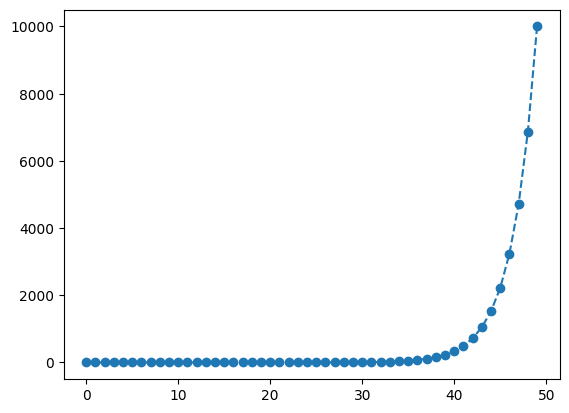

In [68]:
lambdas = np.logspace(-4, 4, 50)
plt.plot(lambdas, linestyle='--', marker='o')
plt.show()

In [69]:
lambdas

array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])

In [73]:
%%time
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(LogisticRegression(penalty='l2',solver="newton-cg"),
                           {'C': 1/lambdas}, cv=5, return_train_score=False)
grid_search.fit(X, y)

CPU times: user 3min 38s, sys: 1min 24s, total: 5min 3s
Wall time: 31 s


GridSearchCV(cv=5, estimator=LogisticRegression(solver='newton-cg'),
             param_grid={'C': array([1.00000000e+04, 6.86648845e+03, 4.71486636e+03, 3.23745754e+03,
       2.22299648e+03, 1.52641797e+03, 1.04811313e+03, 7.19685673e+02,
       4.94171336e+02, 3.39322177e+02, 2.32995181e+02, 1.59985872e+02,
       1.09854114e+02, 7.54312006e+01, 5.17947468e+01, 3.55648031e+01,
       2.44205309e+01, 1.676...
       1.20679264e+00, 8.28642773e-01, 5.68986603e-01, 3.90693994e-01,
       2.68269580e-01, 1.84206997e-01, 1.26485522e-01, 8.68511374e-02,
       5.96362332e-02, 4.09491506e-02, 2.81176870e-02, 1.93069773e-02,
       1.32571137e-02, 9.10298178e-03, 6.25055193e-03, 4.29193426e-03,
       2.94705170e-03, 2.02358965e-03, 1.38949549e-03, 9.54095476e-04,
       6.55128557e-04, 4.49843267e-04, 3.08884360e-04, 2.12095089e-04,
       1.45634848e-04, 1.00000000e-04])})

In [74]:
grid_search.best_params_

{'C': 5.4286754393238645}

In [75]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.143929,0.035623,0.008021,0.000474,10000.0,{'C': 10000.0},0.868750,0.834375,0.903125,0.846875,0.831250,0.856875,0.026619,16
1,0.138326,0.021912,0.010381,0.002096,6866.48845,{'C': 6866.488450042998},0.868750,0.834375,0.903125,0.846875,0.831250,0.856875,0.026619,16
2,0.119503,0.007630,0.009043,0.001240,4714.866363,{'C': 4714.866363457394},0.868750,0.834375,0.903125,0.846875,0.831250,0.856875,0.026619,16
3,0.126119,0.011063,0.008278,0.000663,3237.457543,{'C': 3237.4575428176436},0.868750,0.834375,0.903125,0.846875,0.831250,0.856875,0.026619,16
4,0.151360,0.068940,0.008050,0.000363,2222.996483,{'C': 2222.9964825261955},0.868750,0.834375,0.903125,0.846875,0.831250,0.856875,0.026619,16
5,0.127983,0.022851,0.010895,0.002659,1526.417967,{'C': 1526.4179671752333},0.868750,0.834375,0.903125,0.846875,0.831250,0.856875,0.026619,16
6,0.129434,0.018687,0.010188,0.003016,1048.113134,{'C': 1048.1131341546852},0.868750,0.834375,0.903125,0.846875,0.831250,0.856875,0.026619,16
7,0.119149,0.013242,0.008070,0.000821,719.685673,{'C': 719.6856730011522},0.868750,0.831250,0.903125,0.846875,0.828125,0.855625,0.027769,24
8,0.136151,0.020507,0.008943,0.000980,494.171336,{'C': 494.1713361323838},0.859375,0.831250,0.903125,0.846875,0.828125,0.853750,0.027128,26
9,0.117821,0.023486,0.007878,0.000387,339.322177,{'C': 339.32217718953297},0.859375,0.837500,0.903125,0.846875,0.828125,0.855000,0.026190,25


In [80]:
C = grid_search.best_params_['C']

# valor de lambda
1 / grid_search.best_params_['C']

0.18420699693267145

In [81]:
clasificador_ridge = LogisticRegression(penalty= 'l2',
                                        C = C,
                                        random_state=4,
                                        solver="newton-cg").fit(X_train, y_train)

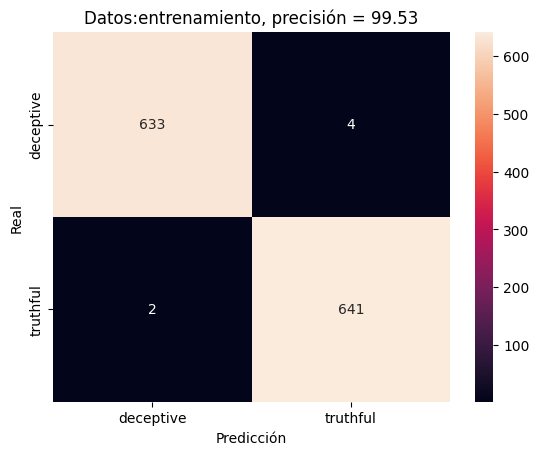

In [82]:
evaluación(clasificador_ridge, 'entrenamiento')

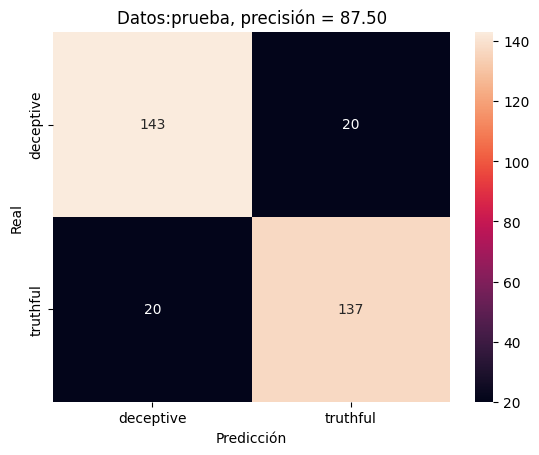

In [83]:
evaluación(clasificador_ridge, 'prueba')

# Predicciones y certeza de la predicción

In [84]:
resultados = {'P(deceptive)' : clasificador_ridge.predict_proba(X_test)[:,0],
              'P(truthful)' : clasificador_ridge.predict_proba(X_test)[:,1],
              'y_pred_50' : clasificador_ridge.predict(X_test),
              }

predicciones = pd.DataFrame(resultados)
predicciones.sort_values('P(deceptive)',
                         ascending=False).iloc[125:165]

,P(deceptive),P(truthful),y_pred_50
297,0.654413,0.345587,deceptive
24,0.649089,0.350911,deceptive
22,0.646050,0.353950,deceptive
264,0.635213,0.364787,deceptive
295,0.634501,0.365499,deceptive
4,0.625694,0.374306,deceptive
100,0.610088,0.389912,deceptive
244,0.605018,0.394982,deceptive
301,0.603729,0.396271,deceptive
6,0.601273,0.398727,deceptive


In [85]:
predicciones['y_pred_30'] = np.where( predicciones['P(deceptive)'] > 0.3, 'deceptive', 'truthful')
predicciones.sort_values('P(deceptive)',
                         ascending=False).iloc[125:165]

,P(deceptive),P(truthful),y_pred_50,y_pred_30
297,0.654413,0.345587,deceptive,deceptive
24,0.649089,0.350911,deceptive,deceptive
22,0.646050,0.353950,deceptive,deceptive
264,0.635213,0.364787,deceptive,deceptive
295,0.634501,0.365499,deceptive,deceptive
4,0.625694,0.374306,deceptive,deceptive
100,0.610088,0.389912,deceptive,deceptive
244,0.605018,0.394982,deceptive,deceptive
301,0.603729,0.396271,deceptive,deceptive
6,0.601273,0.398727,deceptive,deceptive


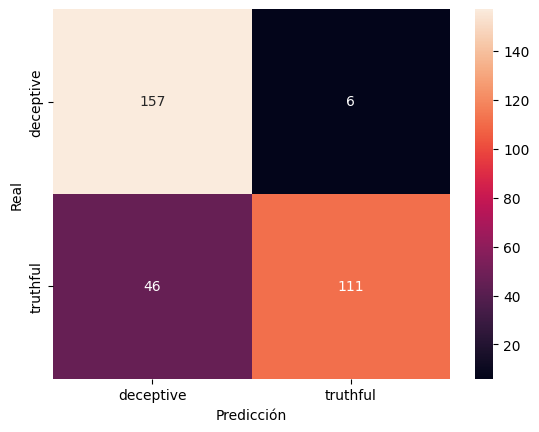

In [86]:
# creamos un diccionario con las etiquetas
data = {'y_Real':  y_test.to_numpy(),
        'y_Prediccion': predicciones['y_pred_30']
        }
# lo convertimos en un DataFrame de pandas
df = pd.DataFrame(data, columns=['y_Real','y_Prediccion'])

# hacemos una tabla crusada para obtener la matriz de confusión
confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'],
                                rownames=['Real'], colnames=['Predicción'])

# realizamos un mapa de calor

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

### grafica_roc
Area bajo la curva entre:

- True Positive Rate  (Sensitivity) :   Verdaderos Positivos / Positivos


- False Positive Rate (1-Specificity): Falsos Positivos / Negativos    


In [97]:
ytest_bin = np.where(y_test=='deceptive', 0, 1)

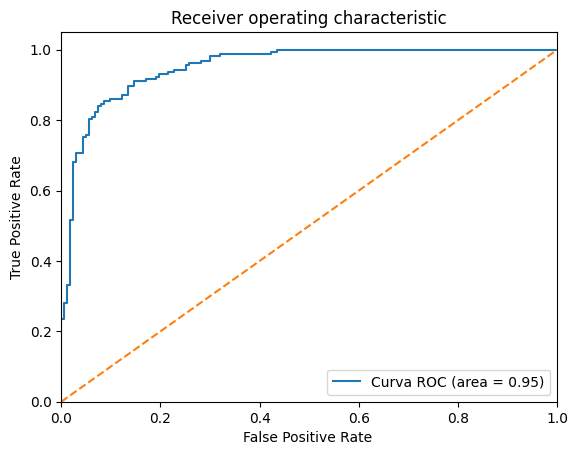

In [96]:
grafica_roc(clasificador_ridge, ytest_bin)

In [95]:
y_test_score = clasificador_ridge.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve( ytest_bin, y_test_score)

roc_df = pd.DataFrame({'fpr': fpr,
                       'tpr':tpr,
                       'thresholds': thresholds,
                       'umbral_decision': MinMaxScaler().fit_transform(thresholds.reshape(-1,1))[:,0],
                       'distancia': np.sqrt((fpr)**2 + (1-tpr)**2),
                       })

roc_df

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [94]:
roc_df.sort_values('distancia').head(1)

NameError: name 'roc_df' is not defined

# Magnitud de los coeficientes para ambos modelos

In [ ]:
clasificador_rl.coef_[0].shape

(3597,)

In [ ]:
coeficientes_rl = pd.Series(clasificador_rl.coef_[0],
                            index=palabras,
                            name='Sin regularización').sort_values(ascending=False)
coeficientes_rl

floor         38.320207
street        36.821836
locat         34.552529
small         31.865226
elev          31.243518
                ...    
recent       -27.625846
relax        -28.728548
millennium   -30.208334
luxuri       -40.941311
chicago      -60.979989
Name: Sin regularización, Length: 3597, dtype: float64

In [ ]:
coeficientes_ridge = pd.Series(clasificador_ridge.coef_[0],
                               index=palabras,
                               name='Ridge').sort_values(ascending=False)
coeficientes_ridge

floor         4.169108
locat         4.131653
elev          3.624349
small         3.526926
street        3.453209
                ...   
millennium   -3.228035
relax        -3.261381
experi       -3.410476
luxuri       -5.182470
chicago      -7.734443
Name: Ridge, Length: 3597, dtype: float64

In [ ]:
np.exp(coeficientes_ridge)

floor         64.657771
locat         62.280802
elev          37.500287
small         34.019242
street        31.601630
                ...    
millennium     0.039635
relax          0.038335
experi         0.033025
luxuri         0.005614
chicago        0.000437
Name: Ridge, Length: 3597, dtype: float64

In [ ]:

coeficientes_ridge.min(), coeficientes_ridge.max()

(-7.7344425016311895, 4.1691083065408225)

In [ ]:
# Observa las magnitudes de los coeficientes del modelo
#  sin y con regularización Ridge
coef = pd.concat([coeficientes_rl,coeficientes_ridge], axis=1)
coef

,Sin regularización,Ridge
floor,38.320207,4.169108
street,36.821836,3.453209
locat,34.552529,4.131653
small,31.865226,3.526926
elev,31.243518,3.624349
...,...,...
recent,-27.625846,-3.133973
relax,-28.728548,-3.261381
millennium,-30.208334,-3.228035
luxuri,-40.941311,-5.182470


In [ ]:
# importancia de las palabras para predecir que es falsa la reseña
np.exp(coef).sort_values(by='Ridge')

,Sin regularización,Ridge
chicago,3.286452e-27,0.000437
luxuri,1.657351e-18,0.005614
experi,7.229544e-12,0.033025
relax,3.336954e-13,0.038335
millennium,7.597790e-14,0.039635
...,...,...
street,9.806635e+15,31.601630
small,6.900681e+13,34.019242
elev,3.705847e+13,37.500287
locat,1.013847e+15,62.280802


# Recursos

Para profundizar en grid_search_cv

https://github.com/codebasics/py/blob/master/ML/15_gridsearch/15_grid_search.ipynb